<a href="https://colab.research.google.com/github/namakutiwik/New-York-CitiBike/blob/main/EDA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Install Mount Drive & Import Dataset

In [1]:
#from google.colab import drive
#drive.mount('/content/drive')

In [2]:
#!ls

In [3]:
# Stations dataset
#stations = pd.read_csv('/content/drive/My Drive/Kemenkes - Data Analyst/stations.csv')
#stations.head(2)

In [4]:
# Trips dataset
#trip = pd.read_csv('/content/drive/My Drive/Kemenkes - Data Analyst/trips.csv')
#trip = trip.drop_duplicates()
#trips = trip.iloc[1: , :]
#trips.head(2)

# Import Dataset from API Bigquery

**For small dataset**

In [5]:
from google.colab import auth
auth.authenticate_user()
print('Authenticated')

Authenticated


In [6]:
%%bigquery --project my-first-project-318200 df
SELECT 
  *
FROM `bigquery-public-data.new_york_citibike.citibike_stations`

In [7]:
stations = df
stations.head(2)

,station_id,name,short_name,latitude,longitude,region_id,rental_methods,capacity,eightd_has_key_dispenser,num_bikes_available,num_bikes_disabled,num_docks_available,num_docks_disabled,is_installed,is_renting,is_returning,eightd_has_available_keys,last_reported
0,3321,Clinton St & Union St,4266.03,-73.997853,40.683116,71.0,"KEY,CREDITCARD",38,False,38,0,0,0,True,True,True,False,2021-07-03
1,3697,W 64 St & Thelonious Monk Circle,7123.04,-73.989187,40.775160,71.0,"KEY,CREDITCARD",43,False,43,0,0,0,True,True,True,False,2021-07-03


**For big dataset**

In [8]:
project_id = 'my-first-project-318200'

In [9]:
from google.cloud import bigquery

client = bigquery.Client(project=project_id)

sample_count = 2000
row_count = client.query('''
  SELECT 
    COUNT(*) as total
  FROM `bigquery-public-data.new_york_citibike.citibike_trips`''').to_dataframe().total[0]

df = client.query('''
  SELECT
    *
  FROM
    `bigquery-public-data.new_york_citibike.citibike_trips`
  WHERE RAND() < %d/%d
''' % (sample_count, row_count)).to_dataframe()

print('Full dataset has %d rows' % row_count)

Full dataset has 58937715 rows


In [10]:
trips = df
trips.head(2)

,tripduration,starttime,stoptime,start_station_id,start_station_name,start_station_latitude,start_station_longitude,end_station_id,end_station_name,end_station_latitude,end_station_longitude,bikeid,usertype,birth_year,gender,customer_plan
0,1481.0,2016-07-14 17:07:57,2016-07-14 17:32:38,242.0,Carlton Ave & Flushing Ave,40.697787,-73.973736,217.0,Old Fulton St,40.702772,-73.993836,17076.0,Customer,NaN,unknown,
1,935.0,2017-06-28 08:34:40,2017-06-28 08:50:16,3238.0,E 80 St & 2 Ave,40.773914,-73.954395,3164.0,Columbus Ave & W 72 St,40.777057,-73.978985,15800.0,Customer,NaN,unknown,


# Import Library

In [11]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from pandas import *
import seaborn as sns
from matplotlib import rcParams
import datetime as dt
%matplotlib inline
sns.set_style("darkgrid")
plt.rcParams['figure.figsize'] = (12,8)

# Exploratory Data Analysis



*  Top 5 stations with the most starts (showing # of starts)
* Trip duration by user type
* Most popular trips based on start station and stop station)
* Rider behaviour by Gender and Age based on avg trip distance (station to station), median speed (trip duration / distance traveled)
* What is the busiest bike in NYC? How many times was it used? How many minutes was it in use?





Information of trip dataset:
1. Trip Duration (seconds) — How long a trip lasted
2. Start Time and Date - Self explanatory
3. Stop Time and Date - Self explanatory
4. Start Station Name - Self explanatory
5. End Station Name - Self explanatory
6. Station ID - Unique identifier for each station
7. Station Lat/Long - Coordinates
8. Bike ID - unique identifier for each bike
9. User Type (Customer = 24-hour pass or 3-day pass user;  Subscriber = Annual Member) - Customers are usually tourists, subscribers are usually NYC residents
10. Gender (Zero=unknown; 1=male; 2=female) - Usually unknown for customers since they often sign up at a kiosk
11. Year of Birth - Self entered, not validated by an ID.



## Cleaning Trips Dataset

### General

In [12]:
trips.head(2)

,tripduration,starttime,stoptime,start_station_id,start_station_name,start_station_latitude,start_station_longitude,end_station_id,end_station_name,end_station_latitude,end_station_longitude,bikeid,usertype,birth_year,gender,customer_plan
0,1481.0,2016-07-14 17:07:57,2016-07-14 17:32:38,242.0,Carlton Ave & Flushing Ave,40.697787,-73.973736,217.0,Old Fulton St,40.702772,-73.993836,17076.0,Customer,NaN,unknown,
1,935.0,2017-06-28 08:34:40,2017-06-28 08:50:16,3238.0,E 80 St & 2 Ave,40.773914,-73.954395,3164.0,Columbus Ave & W 72 St,40.777057,-73.978985,15800.0,Customer,NaN,unknown,


In [13]:
# Extract year from startime to get the trips' year
trips['trips_year'] = pd.DatetimeIndex(trips['starttime']).year
trips.head(3)

,tripduration,starttime,stoptime,start_station_id,start_station_name,start_station_latitude,start_station_longitude,end_station_id,end_station_name,end_station_latitude,end_station_longitude,bikeid,usertype,birth_year,gender,customer_plan,trips_year
0,1481.0,2016-07-14 17:07:57,2016-07-14 17:32:38,242.0,Carlton Ave & Flushing Ave,40.697787,-73.973736,217.0,Old Fulton St,40.702772,-73.993836,17076.0,Customer,NaN,unknown,,2016.0
1,935.0,2017-06-28 08:34:40,2017-06-28 08:50:16,3238.0,E 80 St & 2 Ave,40.773914,-73.954395,3164.0,Columbus Ave & W 72 St,40.777057,-73.978985,15800.0,Customer,NaN,unknown,,2017.0
2,488.0,2015-04-02 08:48:30,2015-04-02 08:56:38,168.0,W 18 St & 6 Ave,40.739713,-73.994564,362.0,Broadway & W 37 St,40.751726,-73.987535,17655.0,Subscriber,1953.0,male,,2015.0


In [14]:
pd.unique(trips.trips_year)

array([2016., 2017., 2015., 2014., 2018., 2013.,   nan])

In [15]:
# Get only dataset 2015-2017
# Get indexes where name column doesn't have value
indexNames = trips[~(trips['trips_year'] == 2015) & ~(trips['trips_year'] == 2016) & ~(trips['trips_year'] == 2017)].index 
# Delete these row indexes from dataFrame
trips.drop(indexNames , inplace=True)

In [16]:
pd.unique(trips.customer_plan)

array([''], dtype=object)

In [17]:
# remove unnecessary columns
trips.drop(trips.columns[[15]], axis = 1, inplace = True)

In [18]:
trips.head(2)

,tripduration,starttime,stoptime,start_station_id,start_station_name,start_station_latitude,start_station_longitude,end_station_id,end_station_name,end_station_latitude,end_station_longitude,bikeid,usertype,birth_year,gender,trips_year
0,1481.0,2016-07-14 17:07:57,2016-07-14 17:32:38,242.0,Carlton Ave & Flushing Ave,40.697787,-73.973736,217.0,Old Fulton St,40.702772,-73.993836,17076.0,Customer,NaN,unknown,2016.0
1,935.0,2017-06-28 08:34:40,2017-06-28 08:50:16,3238.0,E 80 St & 2 Ave,40.773914,-73.954395,3164.0,Columbus Ave & W 72 St,40.777057,-73.978985,15800.0,Customer,NaN,unknown,2017.0


In [19]:
trips['trips_year'] = trips['trips_year'].astype(int)

### Adjusting Station ID vs Station Name

**Checking the imbalance**

In [20]:
print(len(unique(trips.start_station_id)))
print(len(unique(trips.end_station_id)))

421
429


In [21]:
print(len(unique(trips.start_station_name)))
print(len(unique(trips.end_station_name)))

420
430


In [22]:
id_name_s = trips[['start_station_id','start_station_name','end_station_id', 'end_station_name']]
id_name_s = id_name_s.groupby("start_station_id")
id_name_s = id_name_s.agg({"start_station_name": "nunique"})
id_name_s = id_name_s.reset_index()
len(id_name_s[id_name_s['start_station_name']>=2])

5

In [23]:
id_name_e = trips[['start_station_id','start_station_name','end_station_id', 'end_station_name']]
id_name_e = id_name_e.groupby("end_station_id")
id_name_e = id_name_e.agg({"end_station_name": "nunique"})
id_name_e = id_name_e.reset_index()
len(id_name_e[id_name_e['end_station_name']>=2])

5

In [24]:
id_name_e[id_name_e['end_station_name']>=2].head()

,end_station_id,end_station_name
95,329.0,2
193,468.0,2
229,504.0,2
243,521.0,2
365,3263.0,2


In [25]:
a = trips[trips['end_station_id']==329.0]
unique(a.end_station_name)

array(['Greenwich St & N Moore St', 'Greenwich St & North Moore St'],
      dtype=object)

Since the difference, it should use id rather than name

**Create dataframe as dictionary**

In [26]:
start = trips[['start_station_id', 'start_station_name']]
len(unique(start.start_station_id))

421

In [27]:
start.drop_duplicates(subset='start_station_id', keep="first", inplace=True)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [28]:
start.rename(columns = {'start_station_id':'station_id','start_station_name':'station_name'}, inplace = True)

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4308: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [29]:
end = trips[['end_station_id', 'end_station_name']]
len(unique(end.end_station_id))

429

In [30]:
end.drop_duplicates(subset='end_station_id', keep="first", inplace=True)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [31]:
end.rename(columns = {'end_station_id':'station_id','end_station_name':'station_name'}, inplace = True)

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4308: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [32]:
id_name = pd.concat([start,end])
id_name.drop_duplicates(subset='station_id', keep="first", inplace=True)

In [33]:
id_name['station_id'] = id_name['station_id'].astype(int)

In [34]:
id_name.head(3)

,station_id,station_name
0,242,Carlton Ave & Flushing Ave
1,3238,E 80 St & 2 Ave
2,168,W 18 St & 6 Ave


In [35]:
len(id_name)

524

**Combine the dataframe using lookup func.**

In [36]:
trips['start_station_id_copy'] = trips['start_station_id']
trips['end_station_id_copy'] = trips['end_station_id']

In [37]:
trips.start_station_id_copy.replace(dict(zip(id_name.station_id, id_name.station_name)), inplace=True)
trips.end_station_id_copy.replace(dict(zip(id_name.station_id, id_name.station_name)), inplace=True)

In [38]:
trips.drop(['start_station_name','end_station_name'], 1, inplace=True)

In [39]:
trips.rename(columns = {'start_station_id_copy':'start_station_name','end_station_id_copy':'end_station_name'}, inplace = True)

In [40]:
trips.head(3)

,tripduration,starttime,stoptime,start_station_id,start_station_latitude,start_station_longitude,end_station_id,end_station_latitude,end_station_longitude,bikeid,usertype,birth_year,gender,trips_year,start_station_name,end_station_name
0,1481.0,2016-07-14 17:07:57,2016-07-14 17:32:38,242.0,40.697787,-73.973736,217.0,40.702772,-73.993836,17076.0,Customer,NaN,unknown,2016,Carlton Ave & Flushing Ave,Old Fulton St
1,935.0,2017-06-28 08:34:40,2017-06-28 08:50:16,3238.0,40.773914,-73.954395,3164.0,40.777057,-73.978985,15800.0,Customer,NaN,unknown,2017,E 80 St & 2 Ave,Columbus Ave & W 72 St
2,488.0,2015-04-02 08:48:30,2015-04-02 08:56:38,168.0,40.739713,-73.994564,362.0,40.751726,-73.987535,17655.0,Subscriber,1953.0,male,2015,W 18 St & 6 Ave,Broadway & W 37 St


### Any missing value?

In [41]:
#Percentage of missing data.
def missing_data(df):
    total = df.isna().sum().sort_values(ascending=False)
    percent = round(df.isna().sum() / len(df), 4) * 100
    missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
    return missing_data
missing_data(trips)

,Total,Percent
birth_year,140,11.9
end_station_name,0,0.0
start_station_name,0,0.0
trips_year,0,0.0
gender,0,0.0
usertype,0,0.0
bikeid,0,0.0
end_station_longitude,0,0.0
end_station_latitude,0,0.0
end_station_id,0,0.0


In [42]:
trips[trips['birth_year'].isna()].head()

,tripduration,starttime,stoptime,start_station_id,start_station_latitude,start_station_longitude,end_station_id,end_station_latitude,end_station_longitude,bikeid,usertype,birth_year,gender,trips_year,start_station_name,end_station_name
0,1481.0,2016-07-14 17:07:57,2016-07-14 17:32:38,242.0,40.697787,-73.973736,217.0,40.702772,-73.993836,17076.0,Customer,NaN,unknown,2016,Carlton Ave & Flushing Ave,Old Fulton St
1,935.0,2017-06-28 08:34:40,2017-06-28 08:50:16,3238.0,40.773914,-73.954395,3164.0,40.777057,-73.978985,15800.0,Customer,NaN,unknown,2017,E 80 St & 2 Ave,Columbus Ave & W 72 St
62,1392.0,2016-07-24 13:18:49,2016-07-24 13:42:01,2008.0,40.705693,-74.016777,514.0,40.760875,-74.002777,16329.0,Customer,NaN,unknown,2016,Little West St & 1 Pl,12 Ave & W 40 St
63,5192.0,2016-05-09 16:13:42,2016-05-09 17:40:15,459.0,40.746745,-74.007756,499.0,40.769155,-73.981918,16410.0,Customer,NaN,unknown,2016,W 20 St & 11 Ave,Broadway & W 60 St
72,1140.0,2016-09-12 12:45:44,2016-09-12 13:04:44,3295.0,40.791270,-73.964839,3160.0,40.778968,-73.973747,16826.0,Customer,NaN,unknown,2016,Central Park W & W 96 St,Central Park West & W 76 St


In [43]:
len(trips[(trips['birth_year'].isna()) & (trips['gender']=='unknown')])

140

In [44]:
len(trips[(trips['birth_year'].isna()) & (trips['gender']!='unknown')])

0

In [45]:
trips.dropna(axis = 0, inplace=True)

### Data description

In [46]:
trips.dtypes

tripduration                      float64
starttime                  datetime64[ns]
stoptime                   datetime64[ns]
start_station_id                  float64
start_station_latitude            float64
start_station_longitude           float64
end_station_id                    float64
end_station_latitude              float64
end_station_longitude             float64
bikeid                            float64
usertype                           object
birth_year                        float64
gender                             object
trips_year                          int64
start_station_name                 object
end_station_name                   object
dtype: object

In [47]:
#Ensure data is formatted correctly to avoid errors in the visuals
trips['start_station_id'] = trips['start_station_id'].astype('category')
trips['end_station_id'] = trips['end_station_id'].astype('category')
trips['bikeid'] = trips['bikeid'].astype('category')
trips['birth_year'] = trips['birth_year'].astype('category')
trips['trips_year'] = trips['trips_year'].astype('category')

In [48]:
round(trips.describe(),2)

,tripduration,start_station_latitude,start_station_longitude,end_station_latitude,end_station_longitude
count,1036.00,1036.00,1036.00,1036.00,1036.00
mean,865.34,40.74,-73.99,40.74,-73.99
std,3020.57,0.02,0.02,0.02,0.02
min,69.00,40.65,-74.02,40.65,-74.02
25%,359.75,40.72,-74.00,40.72,-74.00
50%,545.00,40.74,-73.99,40.74,-73.99
75%,956.25,40.75,-73.98,40.75,-73.98
max,93290.00,40.80,-73.93,40.81,-73.93


### Remove broken bike data

In [49]:
#Drop double count
trips = trips.drop(trips.index[(trips['tripduration'] < 90) & 
                  (trips['start_station_name'] == trips['end_station_name'])])

### Remove theft bike data

In [50]:
trips[trips['usertype']=='Subscriber'].quantile([.1, .25, .5, .75], axis = 0)

,tripduration,start_station_latitude,start_station_longitude,end_station_latitude,end_station_longitude
0.10,231.00,40.707179,-74.006818,40.703554,-74.005664
0.25,359.25,40.722055,-73.997890,40.720163,-73.998004
0.50,542.00,40.739126,-73.988084,40.736370,-73.988900
0.75,937.75,40.751873,-73.977910,40.751551,-73.977706


In [51]:
trips[trips['usertype']=='Customer'].quantile([.1, .25, .5, .75], axis = 0)

,tripduration,start_station_latitude,start_station_longitude,end_station_latitude,end_station_longitude
0.10,596.6,40.704371,-74.010836,40.705443,-74.012840
0.25,1107.5,40.716094,-74.006676,40.714417,-74.007851
0.50,1351.0,40.725004,-73.991703,40.726249,-73.996279
0.75,1538.5,40.759966,-73.981387,40.763863,-73.979562


In [52]:
trips.quantile([.1, .25, .5, .75], axis = 0)

,tripduration,start_station_latitude,start_station_longitude,end_station_latitude,end_station_longitude
0.10,231.00,40.707099,-74.006818,40.703554,-74.006180
0.25,360.25,40.721904,-73.997901,40.719582,-73.998102
0.50,545.00,40.739071,-73.988284,40.736197,-73.988900
0.75,962.75,40.751873,-73.977910,40.751551,-73.977706


In [53]:
#Remove anomalies
trips = trips.drop(trips.index[(trips['tripduration'] >= 7200)])

### Export dataset

In [54]:
trips.to_csv (r'trips_cleaned.csv', index = False, header=True)

## Part 1: Top 5 Start Stations

In [55]:
#Data for Top 5 Stations
top5 = trips.groupby('trips_year')['start_station_name'].value_counts().reset_index(name='number_of_start').groupby(['start_station_name']).mean()
top5 = pd.DataFrame(top5.to_records()).sort_values(by=['number_of_start'],ascending=False).head(5)
top5

,start_station_name,number_of_start
306,Stanton St & Chrystie St,7.0
83,Carmine St & 6 Ave,4.5
351,W 42 St & 8 Ave,4.0
316,W 100 St & Broadway,4.0
280,Pier 40 - Hudson River Park,4.0


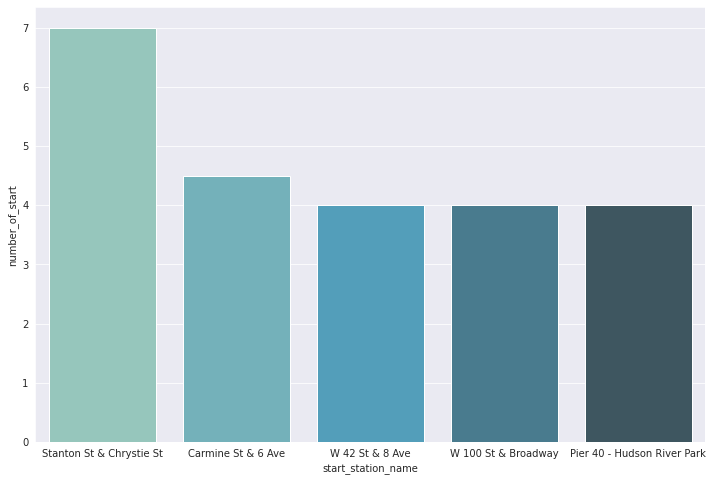

In [56]:
#Barplot
ax1 = sns.barplot(x='start_station_name', y='number_of_start', data = top5, palette="GnBu_d"), #hue='trips_year'
plt.show()

## Part 2: Trip Duration by User Type

In [57]:
#pd.unique(trips.usertype)
a = trips.loc[trips['trips_year'] == 2015]
pd.unique(a.usertype)

array(['Subscriber'], dtype=object)

In [58]:
#Data for Top 5 Stations visual
TD_user = round(trips.groupby(['trips_year','usertype'])['tripduration'].mean().reset_index(name='avg_tripduration'),2)
TD_user = TD_user.dropna(subset=['avg_tripduration'])
TD_user = pd.DataFrame(TD_user.to_records())
TD_user

,index,trips_year,usertype,avg_tripduration
0,1,2015,Subscriber,752.87
1,3,2016,Subscriber,721.89
2,4,2017,Customer,1414.08
3,5,2017,Subscriber,741.55


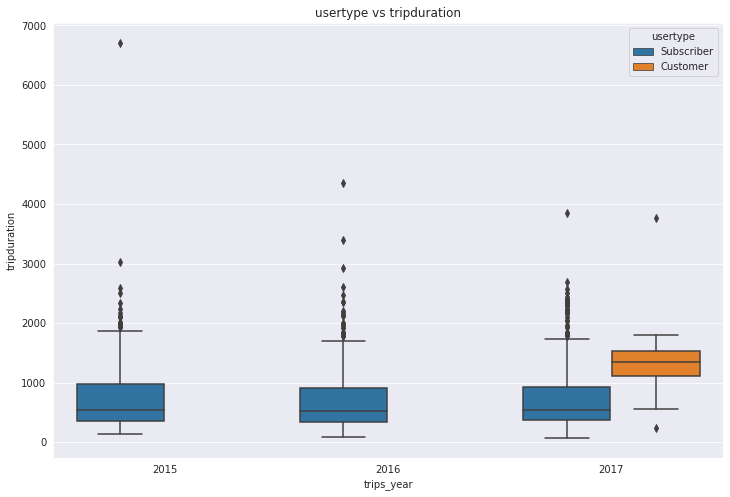

In [59]:
sns.boxplot(x='trips_year', y='tripduration', hue='usertype', data=trips, showfliers=True)
plt.title("usertype vs tripduration", fontsize= 12)
plt.show()

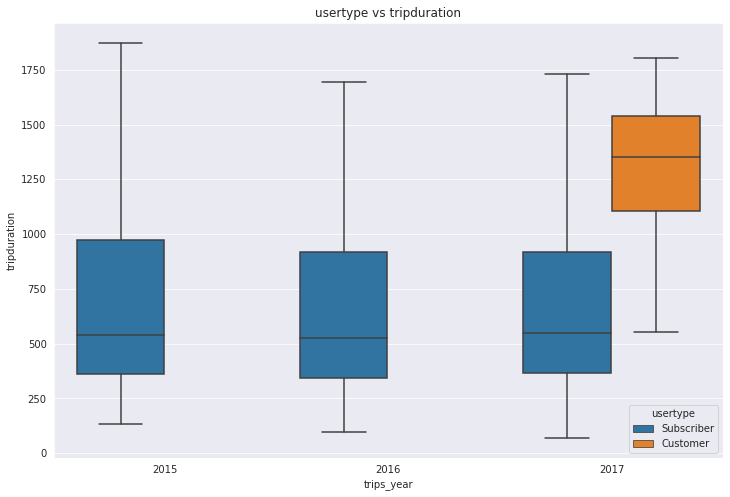

In [60]:
sns.boxplot(x='trips_year', y='tripduration', hue='usertype', data=trips, showfliers=False)
plt.title("usertype vs tripduration", fontsize= 12)
plt.show()

In [61]:
len(trips[(trips['usertype']=='Customer') & (trips['trips_year']==2016)])

0

## Part 3: Most Popular Trip

In [62]:
#Identify the 10 most popular trips
route = pd.DataFrame()
route = trips.groupby(['trips_year','start_station_name','end_station_name']).size().reset_index(name = 'number_of_trips')
route["trip"] = route["start_station_name"] + " -- " + route["end_station_name"]
route = route.drop(['start_station_name', "end_station_name"], axis = 1)
route = route.groupby(['trip'])['number_of_trips'].mean().reset_index(name = 'number_of_trips')
route = route.sort_values('number_of_trips', ascending = False).head(10)
route

,trip,number_of_trips
59036,E 39 St & 3 Ave -- E 48 St & 3 Ave,0.666667
128109,Vesey Pl & River Terrace -- Greenwich St & Nor...,0.666667
42748,Dean St & Hoyt St -- Dean St & 4 Ave,0.666667
56436,E 32 St & Park Ave -- 1 Ave & E 30 St,0.666667
11307,6 Ave & W 33 St -- W 25 St & 6 Ave,0.666667
74940,E 9 St & Avenue C -- Lafayette St & E 8 St,0.666667
25985,Broadway & E 22 St -- 1 Ave & E 18 St,0.666667
21235,Barrow St & Hudson St -- E 10 St & 5 Ave,0.666667
131879,W 15 St & 7 Ave -- W 16 St & The High Line,0.666667
50175,E 16 St & 5 Ave -- Lafayette St & Jersey St,0.666667


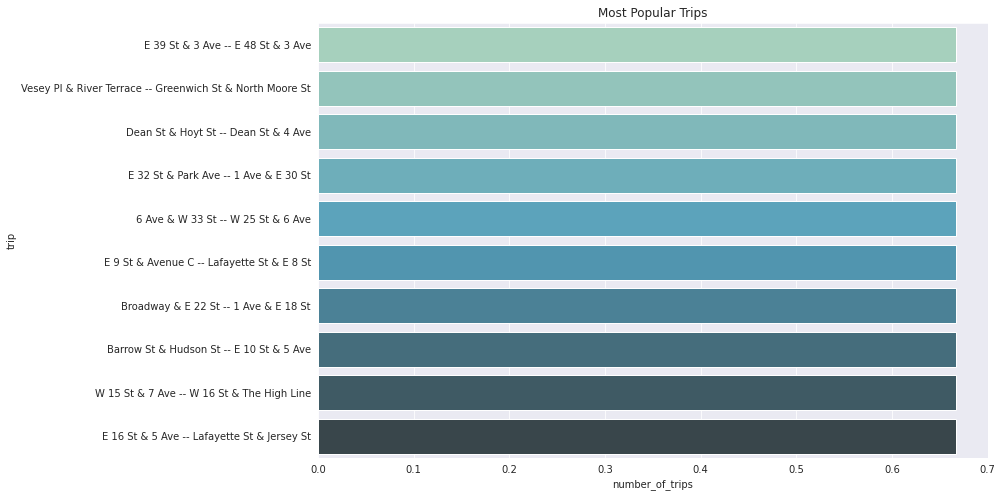

In [63]:
#Barplot
ax2 = sns.barplot(x='number_of_trips', y='trip', data = route, palette="GnBu_d") #hue='trips_year'
ax2.set_title('Most Popular Trips', fontsize = 12)
plt.show()

## Part 4: Rider Behaviour by Gender and Age

In [64]:
behav = trips[["tripduration", "start_station_latitude", "start_station_longitude", "end_station_latitude", "end_station_longitude", "birth_year", "gender", "trips_year"]]
behav['age'] = 2017 - trips['birth_year'].astype(int)
behav.head(2)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,tripduration,start_station_latitude,start_station_longitude,end_station_latitude,end_station_longitude,birth_year,gender,trips_year,age
2,488.0,40.739713,-73.994564,40.751726,-73.987535,1953.0,male,2015,64
4,1158.0,40.727791,-73.985649,40.740259,-73.984092,1955.0,male,2016,62


In [65]:
from math import radians, cos, sin, asin, sqrt

def haversine(lat1, lon1, lat2, lon2):

      R = 3959.87433 # this is in miles.  For Earth radius in kilometers use 6372.8 km

      dLat = radians(lat2 - lat1)
      dLon = radians(lon2 - lon1)
      lat1 = radians(lat1)
      lat2 = radians(lat2)

      a = sin(dLat/2)**2 + cos(lat1)*cos(lat2)*sin(dLon/2)**2
      c = 2*asin(sqrt(a))

      return R * c

In [66]:
dist = []
for ind in trips.index:
    jarak = round(haversine(behav['start_station_latitude'][ind], behav['start_station_longitude'][ind],
                      behav['end_station_latitude'][ind], behav['end_station_longitude'][ind]),2)
    dist.append((jarak))
cols=['jarak']

result = pd.DataFrame(dist, columns=cols)

In [67]:
behav['distance'] = dist

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [68]:
#drop circular round trips
behav = behav.drop(behav.index[(behav['distance'] == 0)])

In [69]:
pd.unique(behav.gender)

array(['male', 'female', 'unknown'], dtype=object)

In [70]:
len(behav[behav['gender'] == 'unknown'])

3

In [71]:
len(behav)

1014

In [72]:
len(behav.index[(behav['age'] >= 100)])

0

In [73]:
behav['mile_per_hour'] = round(behav['distance']/(behav['tripduration']/3600),2)

In [74]:
round(behav.describe(),2)

,tripduration,start_station_latitude,start_station_longitude,end_station_latitude,end_station_longitude,age,distance,mile_per_hour
count,1014.00,1014.00,1014.00,1014.00,1014.00,1014.00,1014.00,1014.00
mean,742.89,40.74,-73.99,40.74,-73.99,39.25,1.11,5.74
std,591.48,0.02,0.02,0.02,0.02,11.55,0.85,1.70
min,69.00,40.66,-74.02,40.66,-74.02,18.00,0.10,0.18
25%,360.25,40.72,-74.00,40.72,-74.00,30.00,0.54,4.62
50%,542.00,40.74,-73.99,40.74,-73.99,37.00,0.83,5.76
75%,944.25,40.75,-73.98,40.75,-73.98,47.00,1.41,6.90
max,6708.00,40.80,-73.93,40.81,-73.93,75.00,6.01,12.38


In [75]:
behav.groupby(['age','gender']).median()['mile_per_hour'].unstack().isnull().sum()

gender
female      6
male        1
unknown    52
dtype: int64

In [76]:
bin = np.linspace(min(behav['age']), max(behav['age']), 15)
len(bin)

15

In [77]:
cat = pd.Series(np.arange(1,len(bin)+1,1))
len(cat)

15

In [78]:
bin = pd.DataFrame(bin)
bin = bin.rename(columns = {0:'bin'})
cat = pd.DataFrame(cat)
cat = cat.rename(columns = {0:'cat'})
age_bin = pd.concat([bin, cat], axis=1)
age_bin['bin2'] = age_bin.bin.shift(1)
age_bin['bin2'] = age_bin['bin2'].replace(np.nan, 0)
age_bin['cat2'] = round(age_bin['bin2'],2).astype(str) + '-' + round(age_bin['bin'],2).astype(str)
age_bin.head()

,bin,cat,bin2,cat2
0,18.000000,1,0.000000,0.0-18.0
1,22.071429,2,18.000000,18.0-22.07
2,26.142857,3,22.071429,22.07-26.14
3,30.214286,4,26.142857,26.14-30.21
4,34.285714,5,30.214286,30.21-34.29


In [79]:
def f(behav):
    if behav['age'] > age_bin.iloc[0,2] and behav['age'] <= age_bin.iloc[0,0]:
        val = age_bin.iloc[0,1] 
    elif behav['age'] > age_bin.iloc[1,2] and behav['age'] <= age_bin.iloc[1,0]:
        val = age_bin.iloc[1,1]
    elif behav['age'] > age_bin.iloc[2,2] and behav['age'] <= age_bin.iloc[2,0]:
        val = age_bin.iloc[2,1]
    elif behav['age'] > age_bin.iloc[3,2] and behav['age'] <= age_bin.iloc[3,0]:
        val = age_bin.iloc[3,1]
    elif behav['age'] > age_bin.iloc[4,2] and behav['age'] <= age_bin.iloc[4,0]:
        val = age_bin.iloc[4,1]
    elif behav['age'] > age_bin.iloc[5,2] and behav['age'] <= age_bin.iloc[5,0]:
        val = age_bin.iloc[5,1]
    elif behav['age'] > age_bin.iloc[6,2] and behav['age'] <= age_bin.iloc[6,0]:
        val = age_bin.iloc[6,1]
    elif behav['age'] > age_bin.iloc[7,2] and behav['age'] <= age_bin.iloc[7,0]:
        val = age_bin.iloc[7,1]
    elif behav['age'] > age_bin.iloc[8,2] and behav['age'] <= age_bin.iloc[8,0]:
        val = age_bin.iloc[8,1]
    elif behav['age'] > age_bin.iloc[9,2] and behav['age'] <= age_bin.iloc[9,0]:
        val = age_bin.iloc[9,1]
    elif behav['age'] > age_bin.iloc[10,2] and behav['age'] <= age_bin.iloc[10,0]:
        val = age_bin.iloc[10,1]
    elif behav['age'] > age_bin.iloc[11,2] and behav['age'] <= age_bin.iloc[11,0]:
        val = age_bin.iloc[11,1]
    elif behav['age'] > age_bin.iloc[12,2] and behav['age'] <= age_bin.iloc[12,0]:
        val = age_bin.iloc[12,1]
    elif behav['age'] > age_bin.iloc[13,2] and behav['age'] <= age_bin.iloc[13,0]:
        val = age_bin.iloc[13,1]
    else:
        val = age_bin.iloc[14,1]
    return val

#create new column 'Good' using the function above
behav['age_cat'] = behav.apply(f, axis=1)

In [80]:
behav.head(2)

,tripduration,start_station_latitude,start_station_longitude,end_station_latitude,end_station_longitude,birth_year,gender,trips_year,age,distance,mile_per_hour,age_cat
2,488.0,40.739713,-73.994564,40.751726,-73.987535,1953.0,male,2015,64,0.91,6.71,13
4,1158.0,40.727791,-73.985649,40.740259,-73.984092,1955.0,male,2016,62,0.87,2.70,12


In [81]:
behav_2015 = behav[behav.trips_year == 2015]
speed_age_gender_2015 = behav_2015.groupby(['trips_year','age_cat','gender']).median()['mile_per_hour'].unstack().sort_values(['trips_year','age_cat'], ascending=True)
speed_age_gender_2015.dropna(inplace=True)

In [82]:
speed_age_gender_2015 = pd.merge(age_bin, speed_age_gender_2015, left_on = 'cat', right_on = 'age_cat', how='right')
speed_age_gender_2015 = speed_age_gender_2015.drop(['bin','cat','bin2'], axis = 1)

In [83]:
behav_2015 = behav[behav.trips_year == 2015]
distance_age_gender_2015 = behav_2015.groupby(['trips_year','age_cat','gender']).median()['distance'].unstack().sort_values(['trips_year','age_cat'], ascending=True)
distance_age_gender_2015.dropna(inplace=True)

In [84]:
distance_age_gender_2015 = pd.merge(age_bin, distance_age_gender_2015, left_on = 'cat', right_on = 'age_cat', how='right')
distance_age_gender_2015 = distance_age_gender_2015.drop(['bin','cat','bin2'], axis = 1)

In [85]:
behav_2016 = behav[behav.trips_year == 2016]
speed_age_gender_2016 = behav_2016.groupby(['trips_year','age_cat','gender']).median()['mile_per_hour'].unstack().sort_values(['trips_year','age_cat'], ascending=True)
speed_age_gender_2016.dropna(inplace=True)

In [86]:
speed_age_gender_2016 = pd.merge(age_bin, speed_age_gender_2016, left_on = 'cat', right_on = 'age_cat', how='right')
speed_age_gender_2016 = speed_age_gender_2016.drop(['bin','cat','bin2'], axis = 1)

In [87]:
behav_2016 = behav[behav.trips_year == 2016]
distance_age_gender_2016 = behav_2016.groupby(['trips_year','age_cat','gender']).median()['distance'].unstack().sort_values(['trips_year','age_cat'], ascending=True)
distance_age_gender_2016.dropna(inplace=True)

In [88]:
distance_age_gender_2016 = pd.merge(age_bin, distance_age_gender_2016, left_on = 'cat', right_on = 'age_cat', how='right')
distance_age_gender_2016 = distance_age_gender_2016.drop(['bin','cat','bin2'], axis = 1)

In [89]:
behav_2017 = behav[behav.trips_year == 2017]
speed_age_gender_2017 = behav_2017.groupby(['trips_year','age_cat','gender']).median()['mile_per_hour'].unstack().sort_values(['trips_year','age_cat'], ascending=True)
speed_age_gender_2017.dropna(inplace=True)

In [90]:
speed_age_gender_2017 = pd.merge(age_bin, speed_age_gender_2017, left_on = 'cat', right_on = 'age_cat', how='right')
speed_age_gender_2017 = speed_age_gender_2017.drop(['bin','cat','bin2'], axis = 1)

In [91]:
behav_2017 = behav[behav.trips_year == 2017]
distance_age_gender_2017 = behav_2017.groupby(['trips_year','age_cat','gender']).median()['distance'].unstack().sort_values(['trips_year','age_cat'], ascending=True)
distance_age_gender_2017.dropna(inplace=True)

In [92]:
distance_age_gender_2017 = pd.merge(age_bin, distance_age_gender_2017, left_on = 'cat', right_on = 'age_cat', how='right')
distance_age_gender_2017 = distance_age_gender_2017.drop(['bin','cat','bin2'], axis = 1)

In [93]:
speed_age_gender = pd.concat([speed_age_gender_2015, speed_age_gender_2016, speed_age_gender_2017], axis=0)
speed_age_gender = speed_age_gender.groupby(['cat2']).mean()
speed_age_gender = pd.merge(speed_age_gender, age_bin, left_on='cat2', right_on='cat2', how='left').sort_values(by='cat')
speed_age_gender.drop(['bin', 'cat', 'bin2'], axis=1, inplace=True)

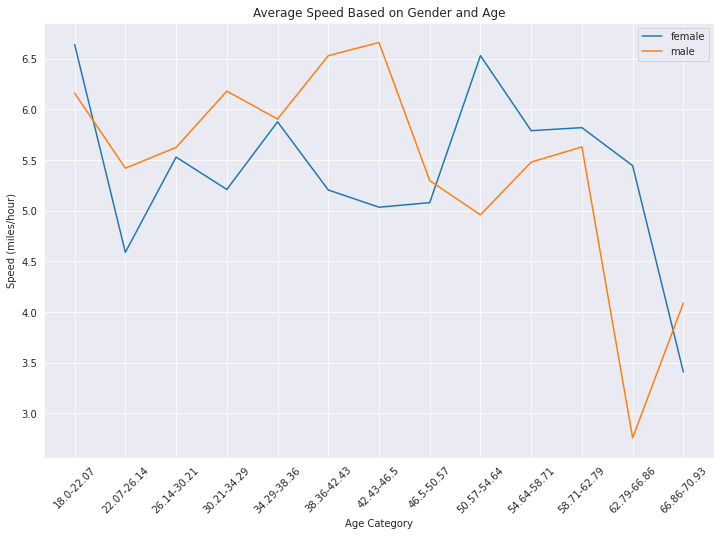

In [94]:
#Barplot
plt.plot(speed_age_gender.cat2, speed_age_gender.female, label = "female")
plt.plot(speed_age_gender.cat2, speed_age_gender.male, label = "male")
plt.legend()
plt.xlabel('Age Category')
plt.ylabel('Speed (miles/hour)')
plt.title('Average Speed Based on Gender and Age')
plt.xticks(rotation=45)
plt.show()

In [95]:
distance_age_gender = pd.concat([distance_age_gender_2015, distance_age_gender_2016, distance_age_gender_2017], axis=0)
distance_age_gender = distance_age_gender.groupby(['cat2']).mean()
distance_age_gender = pd.merge(distance_age_gender, age_bin, left_on='cat2', right_on='cat2', how='left').sort_values(by='cat')
distance_age_gender.drop(['bin', 'cat', 'bin2'], axis=1, inplace=True)

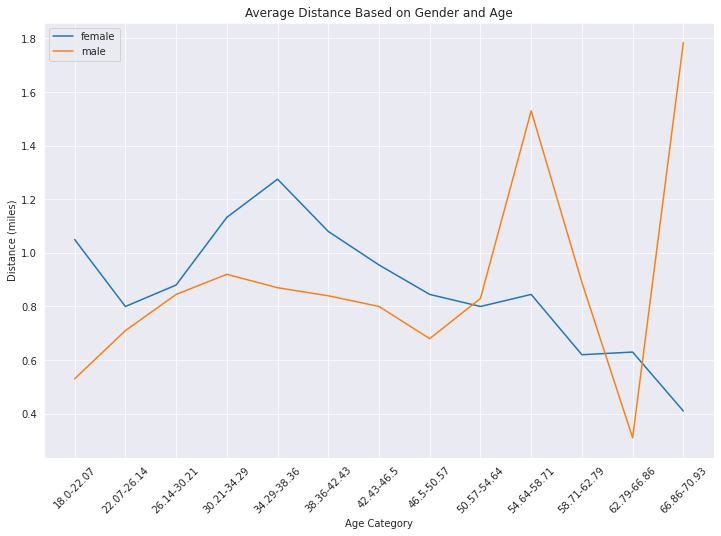

In [96]:
#Barplot
plt.plot(distance_age_gender.cat2, distance_age_gender.female, label = "female")
plt.plot(distance_age_gender.cat2, distance_age_gender.male, label = "male")
plt.legend()
plt.xlabel('Age Category')
plt.ylabel('Distance (miles)')
plt.title('Average Distance Based on Gender and Age')
plt.xticks(rotation=45)
plt.show()

## Part 5: Busiest Bike by Times and Minutes Used

In [97]:
#Bike usage based on number of times used
bike_use = pd.DataFrame()
bike_use = trips.groupby(['trips_year','bikeid']).size().reset_index(name = 'times_used')
bike_use = bike_use.sort_values('times_used', ascending = False)
bike_use['bikeid'] = bike_use['bikeid'].astype(int).astype(str)
bike_use['bikeid'] = ('Bike ' + bike_use['bikeid'])
bike_use = bike_use.groupby('bikeid').mean()['times_used'].reset_index(name = 'times_used').sort_values(by=['times_used'], ascending=False).head(10)
bike_use.head()

,bikeid,times_used
359,Bike 19358,0.666667
956,Bike 30869,0.666667
670,Bike 24875,0.666667
285,Bike 18482,0.666667
444,Bike 20694,0.666667


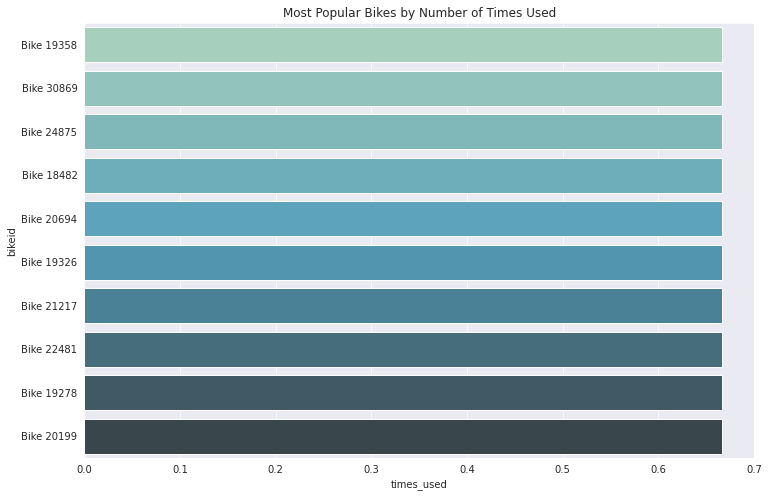

In [98]:
#Barplot
ax2 = sns.barplot(x='times_used', y='bikeid', data = bike_use, palette="GnBu_d")
ax2.set_title('Most Popular Bikes by Number of Times Used', fontsize = 12)
plt.show()

In [99]:
#Bike usage based on minutes used
bike_min = pd.DataFrame()
bike_min['sec_used'] = trips.groupby(['trips_year','bikeid'])['tripduration'].sum()
bike_min['min_used'] = round(bike_min['sec_used']/60,2)
bike_min = bike_min.sort_values('min_used', ascending = False).reset_index()
bike_min['bikeid'] = bike_min['bikeid'].astype(int).astype(str)
bike_min['bikeid'] = ('Bike ' + bike_min['bikeid'])
bike_min.drop(['sec_used'], axis = 1, inplace=True)
bike_min = bike_min.groupby('bikeid').mean()['min_used'].reset_index(name = 'min_used').sort_values(by=['min_used'], ascending=False).head(10)
bike_min.head()

,bikeid,min_used
636,Bike 23853,111.80
798,Bike 26788,72.52
985,Bike 32300,64.18
816,Bike 27102,62.72
574,Bike 22657,56.60


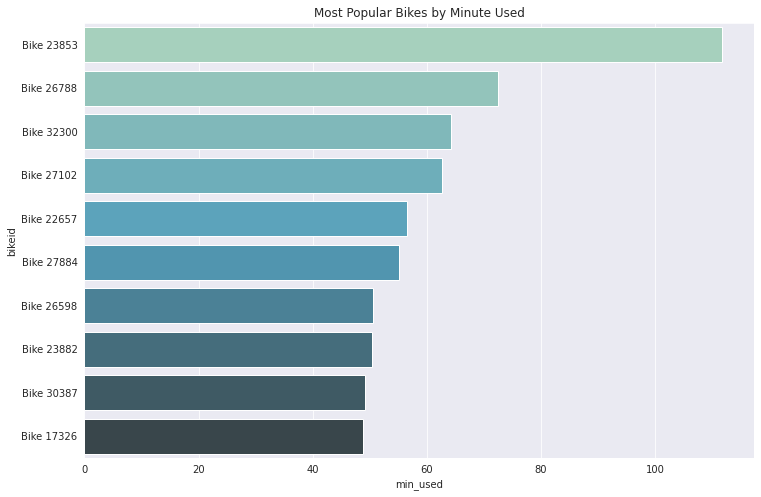

In [100]:
#Barplot
ax2 = sns.barplot(x='min_used', y='bikeid', data = bike_min, palette="GnBu_d")
ax2.set_title('Most Popular Bikes by Minute Used', fontsize = 12)
plt.show()

## Part 6: Distribution Issue

### Rebalancing

In [101]:
# Note that the end station id for one ride is the start station id for the next.
bike_journey = trips.sort_values(by=['bikeid','starttime'])

In [102]:
offset = pd.DataFrame({'starttime': pd.to_datetime('2010-09-01'), 'start_station_name':0,\
                       'stoptime': pd.to_datetime('2010-09-01'),'end_station_name':0,'bikeid':0},index=[0])

In [103]:
bike_journey1 = pd.concat([offset,bike_journey]).reset_index(drop=True)
bike_journey2 = pd.concat([bike_journey,offset]).reset_index(drop=True)

In [104]:
# if end_station_id != start_station_id -> rebalancing 
# Now each row shows the end of one trip and the start of the next.
# This is the time the bike spends at the station between rides.
bike_journey = pd.concat ([bike_journey1[['bikeid','stoptime','end_station_name']]\
                   ,bike_journey2[['bikeid','starttime','start_station_name']] ],\
                    axis=1 )
bike_journey.head()

,bikeid,stoptime,end_station_name,bikeid,starttime,start_station_name
0,0.0,2010-09-01 00:00:00,0,14536.0,2015-11-11 12:38:22,46 Ave & 5 St
1,14536.0,2015-11-11 12:45:09,44 Dr & Jackson Ave,14540.0,2016-05-17 17:44:51,W 13 St & 6 Ave
2,14540.0,2016-05-17 17:56:21,LaGuardia Pl & W 3 St,14545.0,2015-08-20 14:25:32,E 16 St & 5 Ave
3,14545.0,2015-08-20 14:31:07,W 11 St & 6 Ave,14548.0,2015-05-06 12:23:14,5 Ave & E 29 St
4,14548.0,2015-05-06 12:27:50,W 27 St & 7 Ave,14558.0,2017-09-06 17:42:47,W 63 St & Broadway


In [105]:
bike_journey.columns = ['bikeid1','starttime','start_station_name','bikeid2','stoptime','end_station_name']

In [106]:
bike_journey_rebal = bike_journey[['starttime','start_station_name','stoptime','end_station_name']].\
      loc[(bike_journey.bikeid1==bike_journey.bikeid2) & (bike_journey['start_station_name'] != bike_journey['end_station_name'])]
bike_journey_rebal.reset_index(drop=True, inplace=True)
bike_journey_rebal.head()

,starttime,start_station_name,stoptime,end_station_name
0,2015-08-20 06:53:02,1 Ave & E 30 St,2017-06-26 20:20:16,Hudson St & Reade St
1,2016-04-01 11:58:42,Pershing Square North,2016-09-07 12:39:41,1 Ave & E 68 St
2,2015-03-08 09:23:00,9 Ave & W 14 St,2017-07-23 17:22:27,E 15 St & 3 Ave
3,2015-09-23 17:09:51,Vesey Pl & River Terrace,2015-12-21 16:07:31,Broadway & E 22 St
4,2015-09-25 23:44:41,N Henry St & Richardson St,2017-05-03 08:11:51,W 43 St & 6 Ave


### Station Flow

In [107]:
bjs=bike_journey_rebal[['starttime','start_station_name']].assign(in_out=-1) # act as -1 to indicate a bike pick-up
bje=bike_journey_rebal[['starttime','end_station_name']].assign(in_out=1) # act as 1 to indicate a drop off

In [108]:
bjs.columns=['docktime','station_name','in_out']
bje.columns=['docktime','station_name','in_out']
bjse=pd.concat([bjs,bje]).sort_values(by=['station_name','docktime']).reset_index(drop=True)

In [109]:
bjse.head()

,docktime,station_name,in_out
0,2015-08-20 06:53:02,1 Ave & E 30 St,-1
1,2017-07-06 21:36:52,1 Ave & E 30 St,-1
2,2016-04-01 11:58:42,1 Ave & E 68 St,1
3,2017-09-03 11:03:47,8 Ave & W 16 St,1
4,2015-03-08 09:23:00,9 Ave & W 14 St,-1


**Check the station table according its availability**

In [110]:
id_name.head(3)

,station_id,station_name
0,242,Carlton Ave & Flushing Ave
1,3238,E 80 St & 2 Ave
2,168,W 18 St & 6 Ave


In [111]:
# getting bjse with its information
dummy = pd.merge(bjse, id_name, how='inner', left_on='station_name', right_on='station_name')
bjse_info = pd.merge(dummy, stations[['station_id','capacity','num_bikes_available', 'num_docks_available']], how='inner', left_on='station_id', right_on='station_id').drop('station_id', 1)

In [112]:
bjse_info.head()

,docktime,station_name,in_out,capacity,num_bikes_available,num_docks_available
0,2015-08-20 06:53:02,1 Ave & E 30 St,-1,29,21,4
1,2017-07-06 21:36:52,1 Ave & E 30 St,-1,29,21,4
2,2016-04-01 11:58:42,1 Ave & E 68 St,1,62,27,34
3,2015-04-28 17:27:47,9 Ave & W 45 St,1,31,15,14
4,2016-08-13 20:30:52,Allen St & Hester St,-1,79,30,47


**Set the beginning inventory**

Set the num_bikes_availability as the value of beginning inventory

In [113]:
begin_inventory = bjse_info.groupby('station_name').min()['num_bikes_available'].reset_index()

In [114]:
begin_inventory['docktime'] = pd.Timestamp('2010-01-01T12')
begin_inventory = begin_inventory[['docktime', 'station_name', 'num_bikes_available']]
begin_inventory.rename(columns={'num_bikes_available': 'in_out'}, inplace=True)

In [115]:
new_bjse = pd.concat([bjse, begin_inventory], axis=0).sort_values(by=['station_name', 'docktime']).reset_index(drop=True)

In [116]:
new_bjse.head()

,docktime,station_name,in_out
0,2010-01-01 12:00:00,1 Ave & E 30 St,21
1,2015-08-20 06:53:02,1 Ave & E 30 St,-1
2,2017-07-06 21:36:52,1 Ave & E 30 St,-1
3,2010-01-01 12:00:00,1 Ave & E 68 St,27
4,2016-04-01 11:58:42,1 Ave & E 68 St,1


**Calculate the flow**

In [117]:
new_bjse["cum_flow"]=new_bjse.groupby(['station_name'])['in_out'].cumsum(axis=0)

In [118]:
new_bjse['date'] = pd.to_datetime(new_bjse['docktime']).dt.date

In [119]:
new_bjse.head()

,docktime,station_name,in_out,cum_flow,date
0,2010-01-01 12:00:00,1 Ave & E 30 St,21,21,2010-01-01
1,2015-08-20 06:53:02,1 Ave & E 30 St,-1,20,2015-08-20
2,2017-07-06 21:36:52,1 Ave & E 30 St,-1,19,2017-07-06
3,2010-01-01 12:00:00,1 Ave & E 68 St,27,27,2010-01-01
4,2016-04-01 11:58:42,1 Ave & E 68 St,1,28,2016-04-01


### Checking Status

In [120]:
# daily update
bjse_status_in_day = new_bjse.groupby(['station_name', 'date']).last().reset_index().drop(['docktime', 'in_out'], axis=1)

In [121]:
# Put the capacity daily info
z = bjse_info[['station_name','capacity']].drop_duplicates()
new2_bjse= pd.merge(bjse_status_in_day, z, how='inner', left_on='station_name', right_on='station_name')

In [122]:
new2_bjse.loc[(new2_bjse['cum_flow'] < 0), 'inventory'] = 'SHORTAGE'
new2_bjse.loc[(new2_bjse['cum_flow'] == 0), 'inventory'] = 'BALANCE'
new2_bjse.loc[(new2_bjse['cum_flow'] > 0), 'inventory'] = 'SUPRLUS'
new2_bjse.loc[(new2_bjse['cum_flow'] <= new2_bjse['capacity']), 'load'] = 'UNDER'
new2_bjse.loc[(new2_bjse['cum_flow'] > new2_bjse['capacity']), 'load'] = 'OVER'  

In [123]:
new2_bjse['year'] = pd.DatetimeIndex(new2_bjse['date']).year

In [124]:
new2_bjse["status_name"] = new2_bjse["inventory"].astype(str) + " - " + new2_bjse["load"].astype(str)

In [125]:
# count frequency of condition in a year
bjse_status_in_year = new2_bjse.groupby(['station_name','year','status_name']).count()['capacity'].reset_index(name='status_count')

In [126]:
bjse_status_in_year.drop(bjse_status_in_year[bjse_status_in_year['year'] == 2010].index, inplace = True)

In [127]:
bjse_status_in_year.head()

,station_name,year,status_name,status_count
1,1 Ave & E 30 St,2015,SUPRLUS - UNDER,1
2,1 Ave & E 30 St,2017,SUPRLUS - UNDER,1
4,1 Ave & E 68 St,2016,SUPRLUS - UNDER,1
6,9 Ave & W 45 St,2015,SUPRLUS - UNDER,1
8,Allen St & Hester St,2016,SUPRLUS - UNDER,1


In [128]:
sum_distrib = pd.pivot_table(bjse_status_in_year,index=['station_name','year'],columns=['status_name'],values=['status_count'],aggfunc=np.sum).fillna(0)
sum_distrib = pd.DataFrame(sum_distrib.to_records())
sum_distrib.head(2)

,station_name,year,"('status_count', 'SHORTAGE - UNDER')","('status_count', 'SUPRLUS - OVER')","('status_count', 'SUPRLUS - UNDER')"
0,1 Ave & E 30 St,2015,0.0,0.0,1.0
1,1 Ave & E 30 St,2017,0.0,0.0,1.0


In [129]:
sum_distrib.columns = ['station_name', 'year', 'BALANCE-UNDER', 'SURPLUS-OVER', 'SURPLUS-UNDER']

In [130]:
# summary distribution status per year
sum_distrib_per_year=sum_distrib.groupby(['year']).agg({'BALANCE-UNDER':'sum','SURPLUS-OVER':'sum','SURPLUS-UNDER':'sum'}).reset_index()
sum_distrib_per_year

,year,BALANCE-UNDER,SURPLUS-OVER,SURPLUS-UNDER
0,2015,4.0,1.0,26.0
1,2016,0.0,0.0,15.0
2,2017,0.0,1.0,17.0


In [131]:
bjse_status_in_year_visual = bjse_status_in_year.groupby(['year','status_name']).sum()['status_count'].reset_index()
bjse_status_in_year_visual.head()

,year,status_name,status_count
0,2015,SHORTAGE - UNDER,4
1,2015,SUPRLUS - OVER,1
2,2015,SUPRLUS - UNDER,26
3,2016,SUPRLUS - UNDER,15
4,2017,SUPRLUS - OVER,1


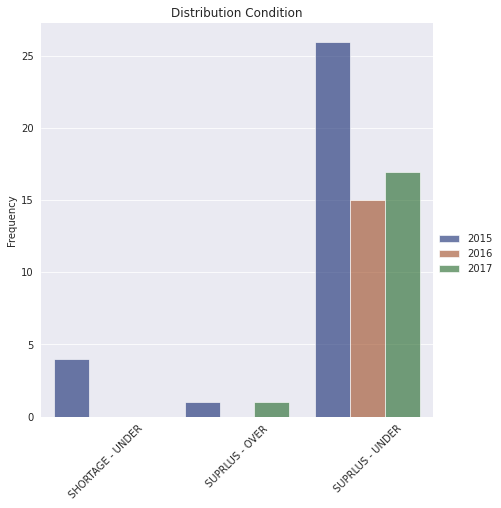

In [132]:
g = sns.catplot(
    data=bjse_status_in_year_visual, kind="bar",
    x="status_name", y="status_count", hue="year",
    ci="sd", palette="dark", alpha=.6, height=6
    )
g.despine(left=True)
g.set_axis_labels("", "Frequency")
g.legend.set_title("")
plt.title("Distribution Condition")
plt.xticks(rotation=45)
plt.show()

In [133]:
# summary distribution status per station in 2017
new2_bjse_xyear = new2_bjse[new2_bjse['year']==2017]
new2_bjse_xyear = new2_bjse_xyear.groupby(['station_name']).agg({'cum_flow':'mean','capacity':'mean'}).reset_index()

In [134]:
new2_bjse_xyear.loc[(new2_bjse_xyear['cum_flow'] == 0) & (new2_bjse_xyear['cum_flow'] <= new2_bjse_xyear['capacity']), 'condition'] = 'BALANCE-UNDER'
new2_bjse_xyear.loc[(new2_bjse_xyear['cum_flow'] < 0) & (new2_bjse_xyear['cum_flow'] <= new2_bjse_xyear['capacity']), 'condition'] = 'SHORTAGE-UNDER'
new2_bjse_xyear.loc[(new2_bjse_xyear['cum_flow'] > 0) & (new2_bjse_xyear['cum_flow'] > new2_bjse_xyear['capacity']), 'condition'] = 'SURPLUS-OVER'
new2_bjse_xyear.loc[(new2_bjse_xyear['cum_flow'] > 0) & (new2_bjse_xyear['cum_flow'] <= new2_bjse_xyear['capacity']), 'condition'] = 'SURPLUS-UNDER'
new2_bjse_xyear.head()

,station_name,cum_flow,capacity,condition
0,1 Ave & E 30 St,19,29,SURPLUS-UNDER
1,Allen St & Rivington St,29,42,SURPLUS-UNDER
2,Bond St & Fulton St,40,47,SURPLUS-UNDER
3,Broadway & E 22 St,2,0,SURPLUS-OVER
4,E 10 St & Avenue A,33,81,SURPLUS-UNDER


In [135]:
balance_under = new2_bjse_xyear[new2_bjse_xyear['condition']=='BALANCE-UNDER'].sort_values(by=['cum_flow'], ascending=False)
shortage_under = new2_bjse_xyear[new2_bjse_xyear['condition']=='SHORTAGE-UNDER'].sort_values(by=['cum_flow'], ascending=True)
surplus_over = new2_bjse_xyear[new2_bjse_xyear['condition']=='SURPLUS-OVER'].sort_values(by=['cum_flow'], ascending=False)
surplus_under = new2_bjse_xyear[new2_bjse_xyear['condition']=='SURPLUS-UNDER'].sort_values(by=['cum_flow'], ascending=False)

In [136]:
print(len(surplus_under))
print(len(surplus_over))

17
1


In [137]:
surplus_under.loc["Total", "cum_flow"] = surplus_under.cum_flow.sum()
surplus_under.tail(1)

,station_name,cum_flow,capacity,condition
Total,NaN,518.0,NaN,NaN


In [138]:
surplus_over.loc["Total", "cum_flow"] = surplus_over.cum_flow.sum()
surplus_over.tail(1)

,station_name,cum_flow,capacity,condition
Total,NaN,2.0,NaN,NaN


It is still possible to distribute from surplus_over to shortage_under

In [139]:
q_surplus_under = surplus_under.quantile([.1, .25, .5, .75], axis = 0)
q2_surplus_under = q_surplus_under.iloc[1,0]
q3_surplus_under = q_surplus_under.iloc[2,0]

In [140]:
def f(row):
    if row['cum_flow'] < q2_surplus_under:
        val = 'low'
    elif row['cum_flow'] > q3_surplus_under:
        val = 'high'
    else:
        val = 'medium'
    return val

surplus_under['priority'] = surplus_under.apply(f, axis=1)

In [141]:
surplus_under.head()

,station_name,cum_flow,capacity,condition,priority
16,W 41 St & 8 Ave,65.0,71.0,SURPLUS-UNDER,high
17,W 43 St & 10 Ave,52.0,79.0,SURPLUS-UNDER,high
14,Schermerhorn St & Court St,47.0,59.0,SURPLUS-UNDER,high
13,Market St & Cherry St,41.0,45.0,SURPLUS-UNDER,high
2,Bond St & Fulton St,40.0,47.0,SURPLUS-UNDER,high


In [142]:
surplus_under_visual = surplus_under.dropna().groupby(['priority']).size().reset_index(name='count')
surplus_under_visual

,priority,count
0,high,8
1,low,5
2,medium,4


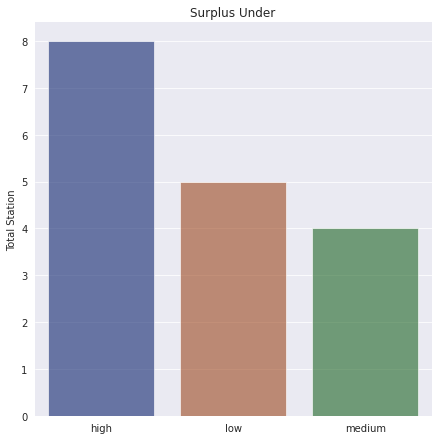

In [143]:
h = sns.catplot(
    data=surplus_under_visual, kind="bar",
    x="priority", y="count",
    ci="sd", palette="dark", alpha=.6, height=6
    )
h.despine(left=True)
h.set_axis_labels("", "Total Station")
plt.title("Surplus Under")
plt.show()

In [144]:
q_surplus_over = surplus_over.quantile([.1, .25, .5, .75], axis = 0)
q2_surplus_over = q_surplus_over.iloc[1,0]
q3_surplus_over = q_surplus_over.iloc[2,0]

In [145]:
def f(row):
    if row['cum_flow'] < q2_surplus_over:
        val = 'high'
    elif row['cum_flow'] > q3_surplus_over:
        val = 'low'
    else:
        val = 'medium'
    return val

surplus_over['priority'] = surplus_over.apply(f, axis=1)

In [146]:
surplus_over.head()

,station_name,cum_flow,capacity,condition,priority
3,Broadway & E 22 St,2.0,0.0,SURPLUS-OVER,medium
Total,NaN,2.0,NaN,NaN,medium


In [147]:
surplus_over_visual = surplus_over.dropna().groupby(['priority']).size().reset_index(name='count')
surplus_over_visual

,priority,count
0,medium,1


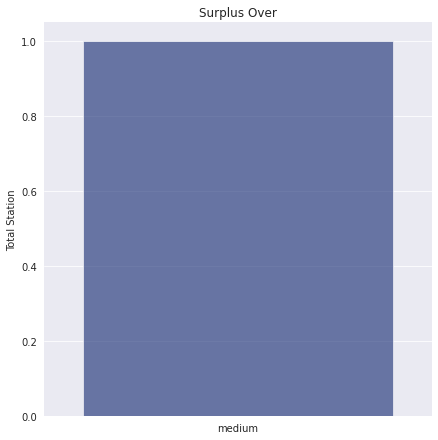

In [148]:
h = sns.catplot(
    data=surplus_over_visual, kind="bar",
    x="priority", y="count",
    ci="sd", palette="dark", alpha=.6, height=6
    )
h.despine(left=True)
h.set_axis_labels("", "Total Station")
plt.title("Surplus Over")
plt.show()

###Check the strange value

In [149]:
k = new_bjse.groupby(['station_name', 'date']).last().reset_index()
k.head()

,station_name,date,docktime,in_out,cum_flow
0,1 Ave & E 30 St,2010-01-01,2010-01-01 12:00:00,21,21
1,1 Ave & E 30 St,2015-08-20,2015-08-20 06:53:02,-1,20
2,1 Ave & E 30 St,2017-07-06,2017-07-06 21:36:52,-1,19
3,1 Ave & E 68 St,2010-01-01,2010-01-01 12:00:00,27,27
4,1 Ave & E 68 St,2016-04-01,2016-04-01 11:58:42,1,28


In [150]:
pd.set_option('display.max_columns', None)
pd.set_option("max_rows", None)
k[k['station_name']=='1 Ave & E 15 St']

,station_name,date,docktime,in_out,cum_flow
